In [2]:
import matplotlib.pyplot as plt
import os
import tqdm
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import numpy as np
from importlib import reload
import pygame

import GamePhysicsSim as GPS
import GamePhysicsSim.Pod as PodClass
from GamePhysicsSim.Config import conf,ROOT_DIR
import GamePhysicsSim.NN as NN
import GamePhysicsSim.Visualise as Visualise

import GamePhysicsSim.Utils as Utils


In [3]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
import sklearn
from sklearn import preprocessing
import pickle

In [4]:
reload(GPS)
reload(GPS.PhysicalObjects)
reload(GPS.Utils)
reload(PodClass)
reload(GPS.Config)
reload(Utils)
reload(NN)

import GamePhysicsSim as GPS
import GamePhysicsSim.Pod as PodClass
from GamePhysicsSim.Config import conf
import GamePhysicsSim.Utils as Utils

In [6]:
from simple_pid import PID

TorqueMax = conf['TorqueMax']
K0 = 10
f0 = 0.12
Kp = K0 * 1
Ki = 5 * Kp * f0
Kd = Kp / (8*f0)
pid = PID(Kp, Ki, Kd, setpoint=0)
pid.output_limits = (-TorqueMax, TorqueMax)


1.3900769197638743


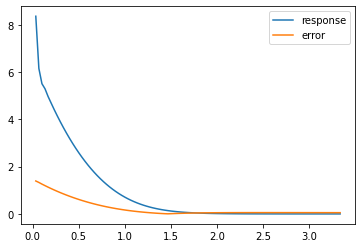

In [7]:
X = 800
Y = 800
AngularDrag = conf['AngularDrag']
AngularFriction = conf['AngularFriction']
Drag = conf['AirDrag']
Friction = conf['Friction']

pod_pos_0 = np.array([np.random.randint(X),np.random.randint(Y)])
theta0 = np.random.uniform(0,2*np.pi)
pod = PodClass.Pod(pos0 = pod_pos_0, w0 = 0, v0 = conf['v0'], a0 = conf['a0'], alpha0 = 0, theta0 = theta0,
                    m=conf['m_pod'], I=conf['I_pod'], TorqueMax = conf['TorqueMax'],
                    ThrustMax = conf['ThrustMax'], vMin = conf['vMin'], wMin = conf['wMin'], wMax = conf['wMax'])

pod.setDest((np.random.randint(X),np.random.randint(Y)))


# K0 = 5
# f0 = 0.3
# Kp = K0 * 1
# Ki = 0.2 * Kp * f0
# Kd = Kp / (9*f0)

K0 = 6
f0 = 0.4
Kp = K0 * 1
Ki = 0.2 * Kp * f0
Kd = Kp / (15*f0)

pod.PID_init(Kp,Ki,Kd)

tMax = 10
dt = 1/30
t=0

error_list = []
response_list = []
t_list = []

while t<tMax: # the main game loop
    t+=dt
    
    Torque,(v_desired,a_required) = pod.GetSteering_PID(pod.dest,dt)
    dist = np.linalg.norm(pod.dest - pod.pos)
    thetaDiff = abs(np.arccos(np.dot(Utils.unit_vector([np.cos(pod.theta),np.sin(pod.theta)]),Utils.unit_vector(pod.dest - pod.pos))))
    # if thetaDiff>(30/360.*2*np.pi):
    #     ThrustGauge = np.clip(np.cos(thetaDiff+30/360.*2*np.pi),0,1)
    # else:
    #     ThrustGauge = np.clip(np.cos(thetaDiff),0,1)
    pod.AddTorque(Torque = Torque)
    pod.Rotate(AngularDrag = AngularDrag, AngularFriction = AngularFriction, dt = dt)
    
    error_list.append(thetaDiff)
    response_list.append(Torque)
    t_list.append(t)
    
end = 100
plt.plot(t_list[:end],response_list[:end],label='response')
plt.plot(t_list[:end],error_list[:end],label='error')
plt.legend();
print(error_list[0])

In [425]:
K0 = 10
f0 = 0.12
Kp = K0 * 1
Ki = 5 * Kp * f0
Kd = Kp / (8*f0)
pod.PID_init(Kp,Ki,Kd)
pod.pid.proportional_on_measurement = False
print(pod.pid(1.268470063651272,1/30))
print(pod.pid(1.1637503085316125,1/30))

30

### Look at different manual alterations of thrust as a function of angle between pod and destination

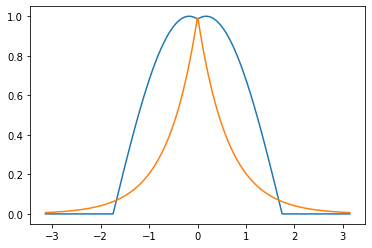

In [506]:
theta = np.linspace(-np.pi,np.pi,500)
plt.plot(theta,[np.clip(np.cos(abs(th)-10/360*2*np.pi),0,1) for th in theta])
plt.plot(theta,[np.clip(np.exp(-abs(th/(np.pi/5))),0,1) for th in theta])

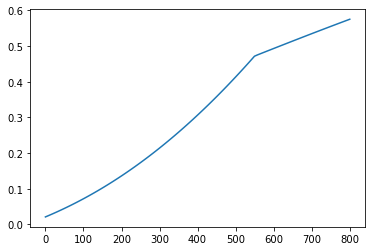

In [488]:
dist_list = np.linspace(0,800,100)
plt.plot(dist_list,[Utils.sigmoid(dist/700.)**2 * np.clip((dist+50)/600.,0,1) for dist in dist_list])